In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import jax.random as r
import distrax as dx
import matplotlib.pyplot as plt
import flax.nnx as nnx
import gpjax as gpx

2024-11-05 14:53:30.074508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730818410.089639 1524135 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730818410.094271 1524135 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/scratch/ww347/projects/Reproductions/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from typing import TypeVar

In [4]:
import sys
import os

# Navigate the current notebook directory to src directory
current_dir = os.getcwd()
jax_eco_dir = os.path.dirname(os.path.dirname(current_dir))
src_dir = os.path.join(jax_eco_dir, 'src')
sys.path.append(jax_eco_dir)

# Now you can import the module
import src.np_from_scratch as npfs

# Regression tutorial
https://docs.jaxgaussianprocesses.com/_examples/regression/

In [5]:
import matplotlib as mpl

cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
key0 = r.key(0)

In [6]:
n = 100
noise = 0.3

key, subkey = r.split(key0)
x = r.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2. * x)
signal = f(x)
y = signal + r.normal(subkey, shape=signal.shape) * noise

In [7]:
D = gpx.Dataset(X=x, y=y)
xtest =  jnp.linspace(-3.5, 3.5, 50).reshape(-1, 1)
ytest = f(xtest)

/scratch/ww347/projects/Reproductions/.venv/lib/python3.11/site-packages/gpjax/dataset.py:43: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
/scratch/ww347/projects/Reproductions/.venv/lib/python3.11/site-packages/gpjax/dataset.py:43: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


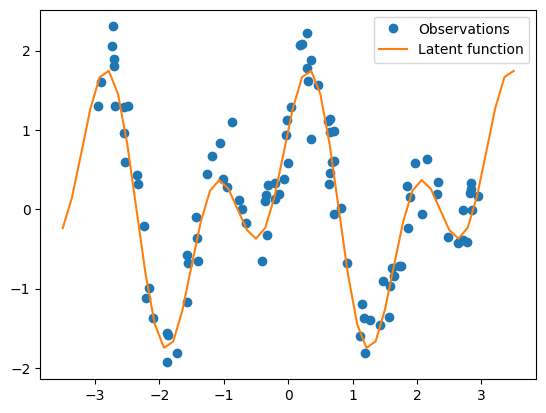

In [8]:
fig, ax = plt.subplots()
ax.plot(x, y, "o", label="Observations", color=cols[0])
ax.plot(xtest, ytest, label="Latent function", color=cols[1])
ax.legend(loc="best")

In [9]:
kernel = gpx.kernels.RBF()
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

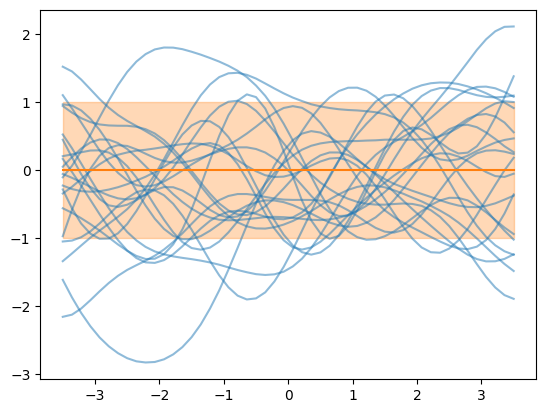

In [10]:
prior_dist = prior.predict(xtest)

prior_mean = prior_dist.mean()
prior_std = prior_dist.stddev()
samples = prior_dist.sample(seed=key, sample_shape=(20,))


fig, ax = plt.subplots()
ax.plot(xtest, samples.T, alpha=0.5, color=cols[0], label="Prior samples")
ax.plot(xtest, prior_mean, color=cols[1], label="Prior mean")
ax.fill_between(
    xtest.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    alpha=0.3,
    color=cols[1],
    label="Prior variance",
)
#ax.legend(loc="best")

In [35]:
xtest.shape

(2, 25, 1)

In [34]:
samples.shape

(20, 50)

Note with 500 datapoints I got nans everywhere!  
Some care will be needed to get exactly what I want!

# Next up: Constructing the posterior
(and beyond!)

In [11]:
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)
posterior = prior * likelihood

In [12]:
print(-gpx.objectives.conjugate_mll(posterior, D))

128.54237


In [13]:
opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    # use negative mll as minimising
    objective=lambda p, d: -gpx.objectives.conjugate_mll(p,d),
    train_data=D,
)

print(-gpx.objectives.conjugate_mll(opt_posterior, D))

         Current function value: 53.761902
         Iterations: 11
         Function evaluations: 85
         Gradient evaluations: 73
53.7619


/scratch/ww347/projects/Reproductions/.venv/lib/python3.11/site-packages/scipy/optimize/_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


### Prediction

In [19]:
latent_dist = opt_posterior.predict(xtest, train_data=D)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

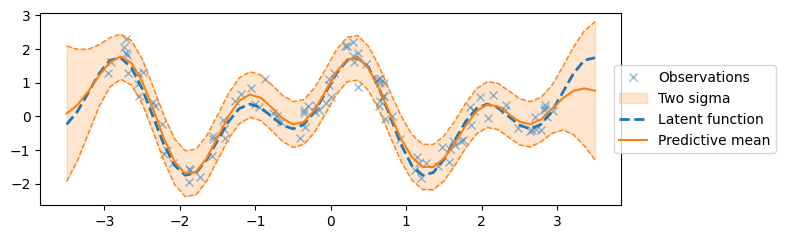

In [20]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.plot(x, y, "x", label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest, ytest, label="Latent function", color=cols[0], linestyle="--", linewidth=2
)
ax.plot(xtest, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))

Comments:
- that all seems nice
- let's build off this!

# Testing reshaping...

In [27]:
xtest =  jnp.linspace(-3.5, 3.5, 50).reshape(2, -1, 1)


In [28]:
xtest.shape

(2, 25, 1)

In [30]:
y_dist = prior.predict(xtest)

In [33]:
y_dist.sample(seed=key, sample_shape=(2,))

Array([[ 0.13893174,  1.3706686 ],
       [-0.5311613 ,  0.02033783]], dtype=float32)